In [12]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import datetime, random, torch
from pprint import pprint
import sys
sys.path.append("../FinRL-Library")
import itertools
import os,json
import argparse
from stable_baselines3.common.logger import configure
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from env.marginEnv import MarginTradingEnv
from env.agent import DRLAgent
from finrl.plot import get_baseline, backtest_stats
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
)

In [4]:
# Directories and datetime setup
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
RESULTS_DIR = RESULTS_DIR + "/" + now + '/a2c'
TENSORBOARD_LOG_DIR = TENSORBOARD_LOG_DIR + "/" + now
TRAINED_MODEL_DIR = TRAINED_MODEL_DIR + "/" + now
MODELS_DIR = "models/" + now

check_and_make_directories([DATA_SAVE_DIR, RESULTS_DIR])

# Seed setup
seed = 0
set_random_seed(seed)

# Argument parsing with Jupyter notebook compatibility
parser = argparse.ArgumentParser(description='margin')

parser.add_argument('--n_steps', type=int, default=5)
parser.add_argument('--gamma', type=float, default=0.99)
parser.add_argument('--lr', type=float, default=0.005)
parser.add_argument('--ent_coef', type=float, default=0.01)
parser.add_argument('--penalty', type=float, default=0.05)

# Add this line to prevent Jupyter's arguments from being processed
args = parser.parse_args(args=[])

In [5]:
DOW_30_TICKER = DOW_30_TICKER 

print(DOW_30_TICKER)
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2018-12-31'
TEST_START_DATE = '2019-01-01'
TEST_END_DATE = '2020-04-30'
TRADE_START_DATE = '2020-05-01'
TRADE_END_DATE = '2023-05-01'

os.makedirs('./datasets', exist_ok=True)
if os.path.exists('./datasets/data.csv'):
    processed = pd.read_csv('./datasets/data.csv',index_col=0)
else:
    df = YahooDownloader(start_date = TRAIN_START_DATE,
                        end_date = TRADE_END_DATE,
                        ticker_list = DOW_30_TICKER).fetch_data() # 97013,8

    df.sort_values(['date','tic']).head()

    fe = FeatureEngineer(use_technical_indicator=True,
                        tech_indicator_list = INDICATORS,
                        use_vix=True,
                        use_turbulence=True,
                        user_defined_feature = False)

    processed = fe.preprocess_data(df)
    processed = processed.copy()
    processed = processed.fillna(0)
    processed = processed.replace(np.inf,0)
    processed.to_csv('./datasets/data.csv')

train = data_split(processed, TRAIN_START_DATE,TRAIN_END_DATE)
test = data_split(processed, TEST_START_DATE,TEST_END_DATE)
trade = data_split(processed, TRADE_START_DATE,TRADE_END_DATE)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [6]:
stock_dimension = len(train.tic.unique())
state_space = 2*3 + 2*stock_dimension + len(INDICATORS)*stock_dimension # cash, long, short, 30 close, 30 holding shares, 30 tech
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension


env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": 2*stock_dimension,
    "reward_scaling": 1e-4,
    'penalty_sharpe': args.penalty
}


e_train_gym = MarginTradingEnv(df = train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()

model_parameters = {'n_steps': args.n_steps, 'ent_coef': args.ent_coef, 'learning_rate': args.lr, 'gamma': args.gamma}
print(model_parameters, 'penalty:', args.penalty)

with open(RESULTS_DIR+'/args.txt', 'w') as f:
    json.dump(args.__dict__, f, indent=2)

Stock Dimension: 29, State Space: 296
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.005, 'gamma': 0.99} penalty: 0.05


In [7]:
print("============Start Training A2C============")
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c", model_kwargs = model_parameters, seed = seed)

tmp_path = RESULTS_DIR 
new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
model_a2c.set_logger(new_logger_a2c)

trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=50000)
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c.pth")

============Start Training A2C============
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.005, 'gamma': 0.99}
Using cuda device
Logging to results/20240825-21h36/a2c/20240825-21h39/a2c
---------------------------------------
| time/                 |             |
|    fps                | 126         |
|    iterations         | 100         |
|    time_elapsed       | 3           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -82.1       |
|    explained_variance | 5.96e-08    |
|    learning_rate      | 0.005       |
|    n_updates          | 99          |
|    policy_loss        | -277        |
|    reward             | -0.89864475 |
|    std                | 1           |
|    value_loss         | 22.1        |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 145       |
|    iterations         | 200       |
|    time_elapsed 

In [8]:
e_test_gym = MarginTradingEnv(df = test, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
test_account_value_a2c, test_actions_a2c,test_state_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_test_gym) 

test_actions_a2c.to_csv(RESULTS_DIR+"/test_actions.csv")
test_state_a2c.to_csv(RESULTS_DIR+"/test_state.csv")

perf_stats = pd.DataFrame(backtest_stats(account_value=test_account_value_a2c))
perf_stats.columns = ['Value']
perf_stats.to_csv(RESULTS_DIR+"/perf_stats_test.csv")



dji_df = get_baseline(
        ticker="^DJI", 
        start = TEST_START_DATE,
        end = TEST_END_DATE)


df_dji = dji_df[["date", "close"]]
fst_day = df_dji["close"][0]
dji = pd.merge(
    df_dji["date"],
    df_dji["close"].div(fst_day).mul(1000000),
    how="outer",
    left_index=True,
    right_index=True,
).set_index("date")

hit end!
Annual return         -0.007662
Cumulative returns    -0.010142
Annual volatility      0.278786
Sharpe ratio           0.111310
Calmar ratio          -0.033888
Stability              0.040020
Max drawdown          -0.226086
Omega ratio            1.022596
Sortino ratio          0.161322
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.189788
Daily value at risk   -0.035001
dtype: float64


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (334, 8)


In [16]:
e_trade_gym = MarginTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
trade_account_value_a2c, trade_actions_a2c, trade_state_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym) 

trade_actions_a2c.to_csv(RESULTS_DIR+"/trade_actions.csv")
trade_state_a2c.to_csv(RESULTS_DIR+"/trade_state.csv")

perf_stats = pd.DataFrame(backtest_stats(account_value=trade_account_value_a2c))
perf_stats.columns = ['Value']
perf_stats.to_csv(RESULTS_DIR+"/perf_stats_trade.csv")


dji_df = get_baseline(
        ticker="^DJI", 
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)


df_dji = dji_df[["date", "close"]]
fst_day = df_dji["close"][0]
dji = pd.merge(
    df_dji["date"],
    df_dji["close"].div(fst_day).mul(1000000),
    how="outer",
    left_index=True,
    right_index=True,
).set_index("date")

[*********************100%***********************]  1 of 1 completed

hit end!
Annual return          0.146169
Cumulative returns     0.503283
Annual volatility      0.266096
Sharpe ratio           0.646155
Calmar ratio           0.517078
Stability              0.720210
Max drawdown          -0.282683
Omega ratio            1.117656
Sortino ratio          0.940849
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.928908
Daily value at risk   -0.032843
dtype: float64
Shape of DataFrame:  (754, 8)


Annual return          0.128900
Cumulative returns     0.437304
Annual volatility      0.172500
Sharpe ratio           0.790368
Calmar ratio           0.587491
Stability              0.337695
Max drawdown          -0.219408
Omega ratio            1.144252
Sortino ratio          1.117012
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.018332
Daily value at risk   -0.021192
dtype: float64


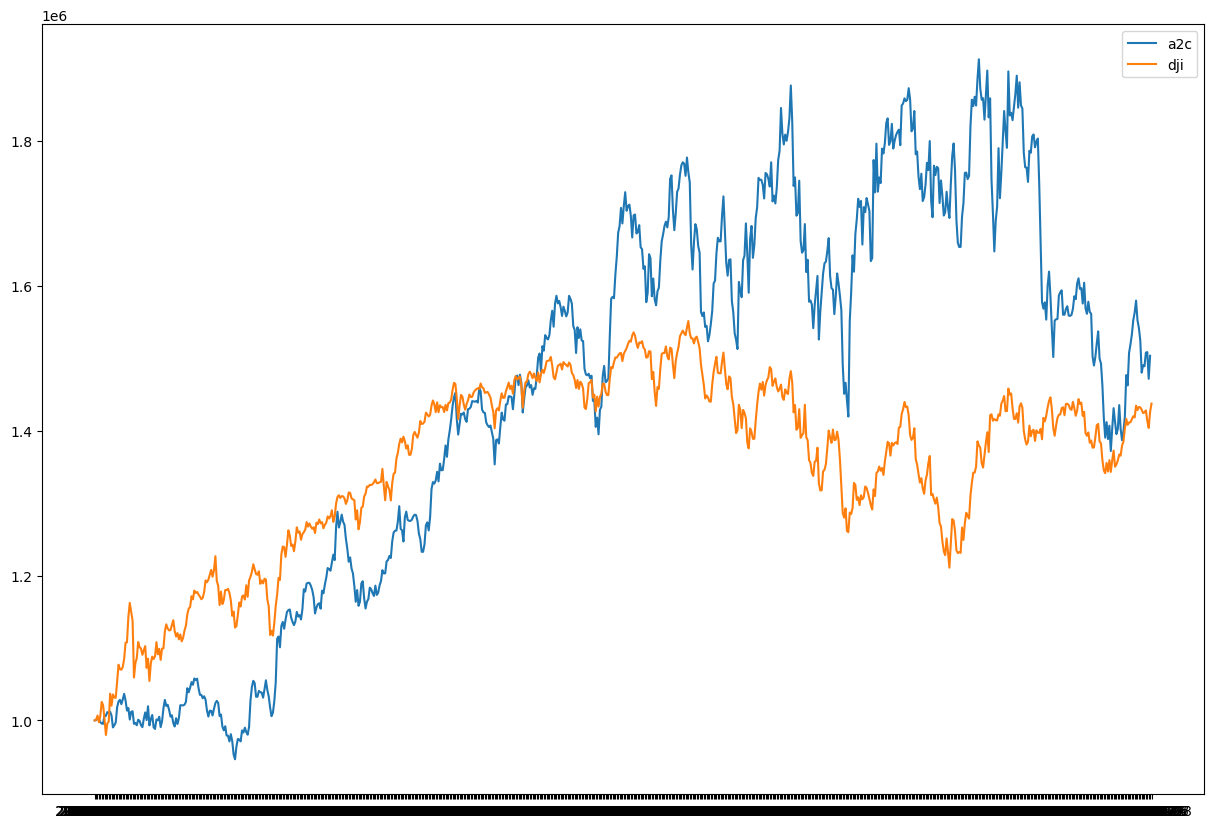

In [17]:
trade_result_a2c = trade_account_value_a2c.set_index(trade_account_value_a2c.columns[0])
result = pd.DataFrame(
    {
        "a2c": trade_result_a2c["account_value"],
        "dji": dji["close"]
    }
)

perf_stats_dji = pd.DataFrame(backtest_stats(dji_df,'close'))
perf_stats_dji.columns = ['Value']
perf_stats_dji.to_csv(RESULTS_DIR+"/perf_stats_dji.csv")



result.to_csv(RESULTS_DIR+"/trade_result.csv")

plt.rcParams["figure.figsize"] = (15,10)
plt.plot(result.a2c,label='a2c')
plt.plot(result.dji,label='dji')
plt.legend(loc='upper right')

plt.show()